# Fairness, Accountability, Transparency and Ethics Course (FATE)

## Universitat Pompeu Fabra (UPF)
### Year 23/24
### Author: Manuel Portela (manuel.portela@upf.edu) with the contribution from Ioannis Bilionis (ibilionis@adherahealth.com)
*** Partially based on the original exercises made by David Solans (david.solans@upf.edu) ***
<br>
<br>
<br>
Submission date: 22/03/2024 at 23:59 on Aula Global

Please, implement this notebook **in pairs**.

<br>
<br>

**Legend** <br>
In this notebook we use:    
<div class="alert alert-block col-md-7 alert-info">To recall information from the theory classes and other tips</div>
<div class="alert alert-block col-md-7 alert-warning">To point important things that should not be 
   forgotten</div> 
<div class="alert alert-block col-md-7 alert-primary bg-primary">LAB TASK</div>

# 3. Part 2: Predicting with a COVID-19 Dataset

This project consist on applying the concepts and the techniques acquired during the course, with the addition of mitigation algorithms. 

The purpose of this project is to train a model that answer a specific question. Each group will have to choose a question and will have a subset of the original dataset to use. 

<div class="alert alert-block alert-info">We will work with subsets obtainef from the full dataset available at <a href="https://www.kaggle.com/datasets/omarlarasa/cov19-open-data-mexico">kaggle</a>.</div>

Use the question that correlates to your group with its corresponding dataset:
1. What is the probability of dying increase with the patient's age? 
2. What does probability change if the patient has another health issue? 
3. How dying probability increases when the patient has been intubated? 
4. Is it true that smoking increases the probability of dying by COV19?
5. Do pregnant women has more probability of being intubated?
6. How is the probability of hospitalization and probability of death are related to the length of symptoms?  
7. Is there a potential discrimination against Migrants? Hint: calculate the ratio between death and ICU/intubation


<div class="alert alert-block alert-success">
    <p><b>[To complete]</b></p>
    <p>Group number: 6</p>
    <p>Group members: Aitana Gonzalez, Berta Mitjavila </p>
    <p>Chosen question: How does the probability of dying from covid vary with the age of the patient?</p>
</div>

###  Libraries used in this notebook
You will need to install: **numpy**, **pandas**, **matplotlib**, and **sklearn**.

In [1]:
## Required statements
import pandas as pd
import numpy as np

from sklearn import linear_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

#!pip install aif360

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult

from aif360.metrics import BinaryLabelDatasetMetric

from IPython.display import Markdown, display


from IPython.display import Markdown, display
import matplotlib.pyplot as plt
%matplotlib inline

# Necessary libraries EXTRA #
import seaborn as sns
from xgboost import XGBClassifier, plot_importance
#!pip install shap
import shap

# Ignore all warnings
import warnings
warnings.simplefilter("ignore")

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.1] Load and analyse your dataset (1 point)</h2>
    <hr>
     <p class="mb-0">Load your assigned dataset and answer the following questions:</p>

   <ol>
    <li>Is it k-anonymous?  [Interpret]</li>
    <li>Does it complies with l-diversity ? [interpret]</li>
    <li>Is it balanced? [Interpret]</li>
    <li>Select your protected class [justify]</li>
    <li>Define sensitive attributes [justify]</li>
   </ol>
</div>

In [2]:
df = pd.read_csv("../Data/deceased_dataset_v1.csv")
df.head()

,respiratory_hospital_unit,sex,admission_date,symptoms_onset_date,decease_date,intubation,pneumonia,age,native_speaker,native_mexican,...,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_renal_failure,smoker,ICU_admission,covid_positive,deceased_patient
0,1.0,1.0,12/10/2020,12/09/2020,12/14/2020,0.0,1.0,76.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,1.0,2.0,07/25/2020,07/18/2020,08/07/2020,0.0,0.0,55.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,1.0,1.0,05/19/2020,05/16/2020,05/23/2020,0.0,1.0,81.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1
3,0.0,2.0,01/19/2021,01/07/2021,01/25/2021,0.0,1.0,76.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,1.0,2.0,05/06/2020,05/02/2020,NaN,NaN,0.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0


In [3]:
df.columns.to_list()

['respiratory_hospital_unit',
 'sex',
 'admission_date',
 'symptoms_onset_date',
 'decease_date',
 'intubation',
 'pneumonia',
 'age',
 'native_speaker',
 'native_mexican',
 'diabetes',
 'epoc',
 'asma',
 'immunosuppression',
 'hypertension',
 'other_diseases',
 'cardiovascular',
 'obesity',
 'chronic_renal_failure',
 'smoker',
 'ICU_admission',
 'covid_positive',
 'deceased_patient']

In [4]:
# We will work only with covid_positive = 1 because we want the probability of dying due to covid
df = df[df['covid_positive'] == 1]

# As covid_positive is always 1, it is unuseful
# Attributes like 'admission_date' are not affected by the age so are irrelevant
df = df.drop(columns=['covid_positive', 'admission_date', 'symptoms_onset_date', 'decease_date', 'respiratory_hospital_unit', 'intubation', 'smoker','ICU_admission'])

df.columns.to_list()

['sex',
 'pneumonia',
 'age',
 'native_speaker',
 'native_mexican',
 'diabetes',
 'epoc',
 'asma',
 'immunosuppression',
 'hypertension',
 'other_diseases',
 'cardiovascular',
 'obesity',
 'chronic_renal_failure',
 'deceased_patient']

In [5]:
df = df.dropna(subset=['age'])

In [6]:
df.head()

,sex,pneumonia,age,native_speaker,native_mexican,diabetes,epoc,asma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_renal_failure,deceased_patient
0,1.0,1.0,76.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,2.0,0.0,55.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
2,1.0,1.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,2.0,1.0,76.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10,2.0,1.0,38.0,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


## K-anonimity

### - Initial Idea -

**Identifiers:** These are unique attributes that can be used to identify an individual. In this dataset, there doesn’t seem to be any explicit identifiers like name, social security number, or patient ID.

**Quasi-identifiers:** These are attributes that, in combination, can be used to identify an individual. In this dataset, the following could be considered quasi-identifiers: ‘age’, 'sex', 'native_speaker’, ‘native_mexican’.

**Sensitive attributes:** These are sensitive attributes that should be protected. In this dataset, the following could be considered confidential attributes: 'sex', 'native_speaker’, ‘native_mexican’.

**Other:** These attributes could also be considered sensitive attributes, however, as far as our study is concerned, they are attributes that are related to a person's state of health, as well as possible habits (such as smoking). These attributes are related to a person's age, so we consider them as "other": 'pneumonia', 'diabetes', 'epoc', 'asma', 'immunosuppression', 'hypertension', 'other_diseases', 'cardiovascular', 'obesity', 'chronic_renal_failure', 'deceased_patient'.

In [7]:
df_anonimity = df[['age', 'sex', 'native_speaker', 'native_mexican', 'deceased_patient']]

In [8]:
## Use a helper function that calculates the groups by value
## If using pandas, you can consider using grouping and group sizes for that
def get_values_frequencies(_df, quasi_identifier_cols):
    _df = _df.groupby(quasi_identifier_cols).size().reset_index(name='Count')
    return _df[_df['Count'] != 0]

## Code a function that uses the function above and determines whether a given dataset satifies K-anonimity 
# for a given K
def is_k_anonymous(_df, K, quasi_identifier_cols):
    value_counts = get_values_frequencies(_df, quasi_identifier_cols)
    max_k = min(value_counts['Count'])
    if K < max_k:
        return str(all(value_counts['Count'] >= K)) + f', and it is {max_k}-anonymous too.'
    else:
        return all(value_counts['Count'] >= K)

In [9]:
print("Given the previously established quasi-identifiers, does the dataset satisfy 2-anonymity)?", is_k_anonymous(df_anonimity, 2, ['age', 'sex', 'native_speaker', 'native_mexican']))


Given the previously established quasi-identifiers, does the dataset satisfy 2-anonymity)? False


As we can observe, with the given quasi-identifiers, the dataset is not 2-anonymous. If a dataset does not satisfy 2-anonymity, it means that there are individuals in the dataset who can be uniquely identified based on the quasi-identifiers.

In [10]:
df_anonimity.groupby(by=['age', 'sex', 'native_speaker', 'native_mexican']).size()


age   sex  native_speaker  native_mexican
12.0  1.0  0.0             0.0                21
                           1.0                 1
      2.0  0.0             0.0                22
13.0  1.0  0.0             0.0                24
      2.0  0.0             0.0                29
                                            ... 
90.0  1.0  1.0             0.0                 1
                           1.0                 2
      2.0  0.0             0.0               185
                           1.0                 1
           1.0             1.0                 4
Length: 525, dtype: int64

The previous output shows the count of records for each unique combination of the four quasi-identifiers, and we can observe that there is an individual that can be uniquely identified.

In [11]:
df_anonimity[(df_anonimity['age'] == 12.0) & (df_anonimity['sex'] == 1.0) & (df_anonimity['native_speaker'] == 0.0) & (df_anonimity['native_mexican'] == 1.0)]


,age,sex,native_speaker,native_mexican,deceased_patient
172362,12.0,1.0,0.0,1.0,0


Given this situation, we will have to **anonymize** the dataset. In this case, we could apply generalization to the ‘age’ attribute.

In [12]:
unique_ages = df_anonimity['age'].unique()
unique_ages.sort()
print(unique_ages)

[12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.
 84. 85. 86. 87. 88. 89. 90.]


In [13]:
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]
labels = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
df_anonimity['age_group'] = pd.cut(df_anonimity['age'], bins=bins, labels=labels, right=False)
df_anonimity = df_anonimity.drop(columns=['age'])
df_anonimity.head()

,sex,native_speaker,native_mexican,deceased_patient,age_group
0,1.0,0.0,0.0,1,70-80
1,2.0,1.0,1.0,1,50-60
2,1.0,0.0,0.0,1,80-90
3,2.0,0.0,0.0,1,70-80
10,2.0,NaN,NaN,1,30-40


We check that there is no individual who can be uniquely identified.

In [14]:
get_values_frequencies(df_anonimity, ['age_group', 'sex', 'native_speaker', 'native_mexican']).sort_values(by="Count", ascending=True)


,age_group,sex,native_speaker,native_mexican,Count
3,10-20,1.0,1.0,1.0,2
10,20-30,1.0,1.0,0.0,2
14,20-30,2.0,1.0,0.0,3
1,10-20,1.0,0.0,1.0,4
7,10-20,2.0,1.0,1.0,4
...,...,...,...,...,...
28,40-50,2.0,0.0,0.0,8537
40,60-70,1.0,0.0,0.0,9261
52,70-80,2.0,0.0,0.0,11198
36,50-60,2.0,0.0,0.0,12476


In [15]:
print("Given the previously established quasi-identifiers, does the dataset satisfy 2-anonymity)?", is_k_anonymous(df_anonimity, 2, ['age_group', 'sex', 'native_speaker', 'native_mexican']))


Given the previously established quasi-identifiers, does the dataset satisfy 2-anonymity)? True


## L-diversity

In [16]:
def is_l_diverse(df, partitions, sensitive_column, l=2):
    #your function here
    
    aux = True
    
    # Step 1: Create Qi groups
    qi_groups = df.groupby(partitions)
    
    # Step 2: Check ℓ-diversity for each Qi group
    for group_name, group_data in qi_groups:
        unique_sensitive_values = group_data[sensitive_column].nunique()
        
        # Check if the number of unique sensitive attribute values is more than ℓ
        if unique_sensitive_values > l:
            print(f'{group_name} -> false')  # Print combination + False
            aux = False  # Dataset does not satisfy ℓ-diversity for this group
    
    # Step 3: All Qi groups satisfy ℓ-diversity
    return f"* l-diversity of the dataset: {aux}"

In [17]:
# Defining groups and sensitive column
target_columns = ['age_group', 'sex', 'native_speaker', 'native_mexican']
sensitive_column = "deceased_patient"

for i in range(2,6):
    print('For l =', i, ': ')
    print(is_l_diverse(df_anonimity, target_columns, sensitive_column, l=i), "\n")

For l = 2 : 
* l-diversity of the dataset: True 

For l = 3 : 
* l-diversity of the dataset: True 

For l = 4 : 
* l-diversity of the dataset: True 

For l = 5 : 
* l-diversity of the dataset: True 



## Balance

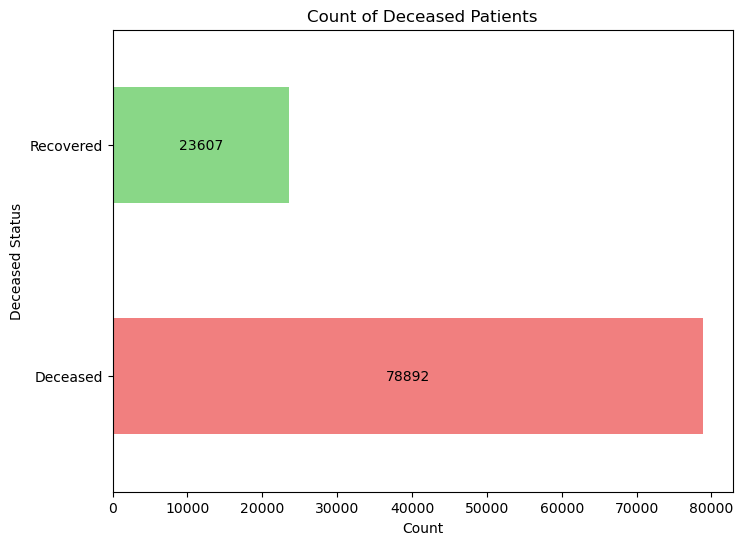

In [18]:
# Balance between recovered vs deceased
counts = df_anonimity['deceased_patient'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
bars = counts.plot(kind='barh', color=['#E50000', '#15B010'], alpha=0.5)  # Using barh() for horizontal bars
plt.title('Count of Deceased Patients')
plt.ylabel('Deceased Status')
plt.xlabel('Count')
plt.yticks(ticks=[0, 1], labels=['Deceased', 'Recovered'])

# Annotating bars with counts
for i, count in enumerate(counts):
    plt.text(y=i, x=count/2, s=str(count), ha='center', va='center')  # Adjusting x and y positions for horizontal bars

plt.show()

As we can observe, regarding "deceased_patients", we could say that the dataset is imbalanced. The factor that there are significantly more deceased patients than recovered ones, could lead the model to become biased towards the majority class.

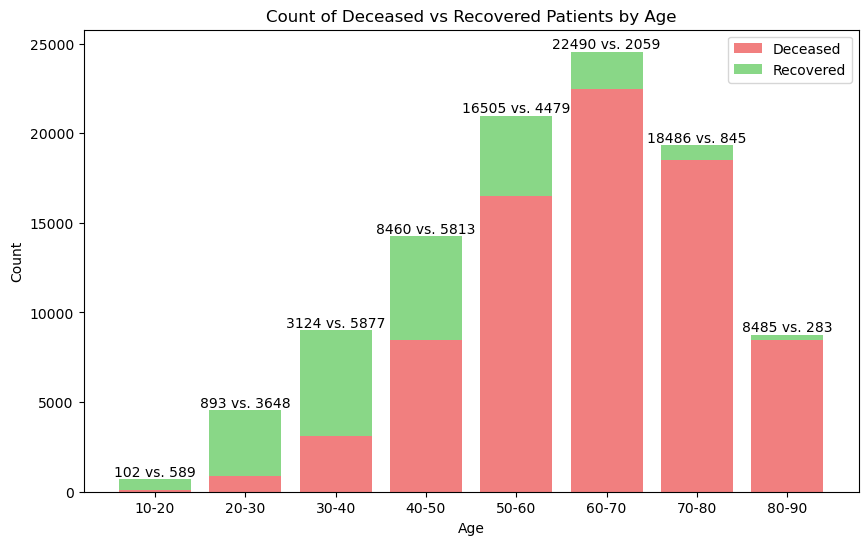

In [19]:
# Group by age and deceased status and count occurrences
counts = df_anonimity.groupby(['age_group', 'deceased_patient']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(10, 6))

# Plot deceased patients
plt.bar(counts.index, counts[1], color='#E50000', label='Deceased', alpha=0.5)

# Plot recovered patients
plt.bar(counts.index, counts[0], bottom=counts[1], color='#15B010', label='Recovered', alpha=0.5)

plt.title('Count of Deceased vs Recovered Patients by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# Annotating bars with counts
for age, (recovered, deceased) in zip(counts.index, counts.values):
    plt.text(age, deceased + recovered, f'{deceased} vs. {recovered}', ha='center', va='bottom')

plt.show()

Again, we can observe that regarding "deceased_patients", we could say that the dataset is imbalanced. This means there are significantly more deceased patients than recovered ones in most age groups and, in this case, especially in the older age groups.

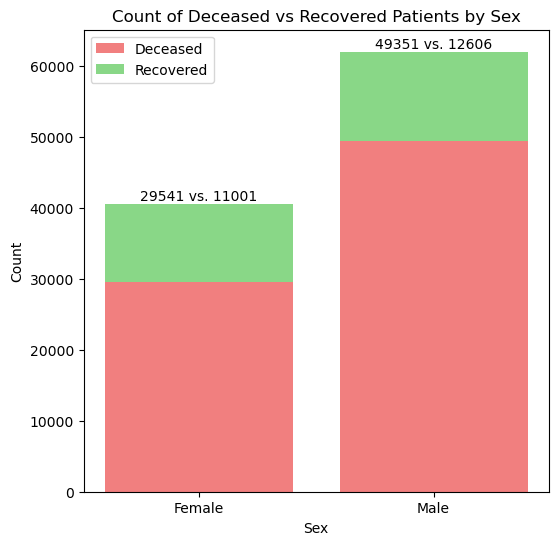

In [20]:
# Group by sex and deceased status and count occurrences
counts = df_anonimity.groupby(['sex', 'deceased_patient']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(6, 6))

# Plot deceased patients
plt.bar(counts.index, counts[1], color='#E50000', label='Deceased', alpha=0.5)

# Plot recovered patients
plt.bar(counts.index, counts[0], bottom=counts[1], color='#15B010', label='Recovered', alpha=0.5)

plt.title('Count of Deceased vs Recovered Patients by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(ticks=[1, 2], labels=['Female', 'Male'])  # 1=Female, 2=Male
plt.legend()

# Annotating bars with counts
for sex, (recovered, deceased) in zip(counts.index, counts.values):
    plt.text(sex, deceased + recovered, f'{deceased} vs. {recovered}', ha='center', va='bottom')

plt.show()

The dataset, again, is imbalanced across different genders. This means there are significantly more deceased males than recovered ones, and significantly more recovered females than deceased ones.
As usual, there are more males than females in the dataset.


In [21]:
df_anonimity[['sex', "deceased_patient"]].groupby('sex', as_index=False).mean().round(4)

,sex,deceased_patient
0,1.0,0.7287
1,2.0,0.7965


This output suggests that the average rate of deceased patients is slightly higher for the ‘sex’ category Male compared to Female. 

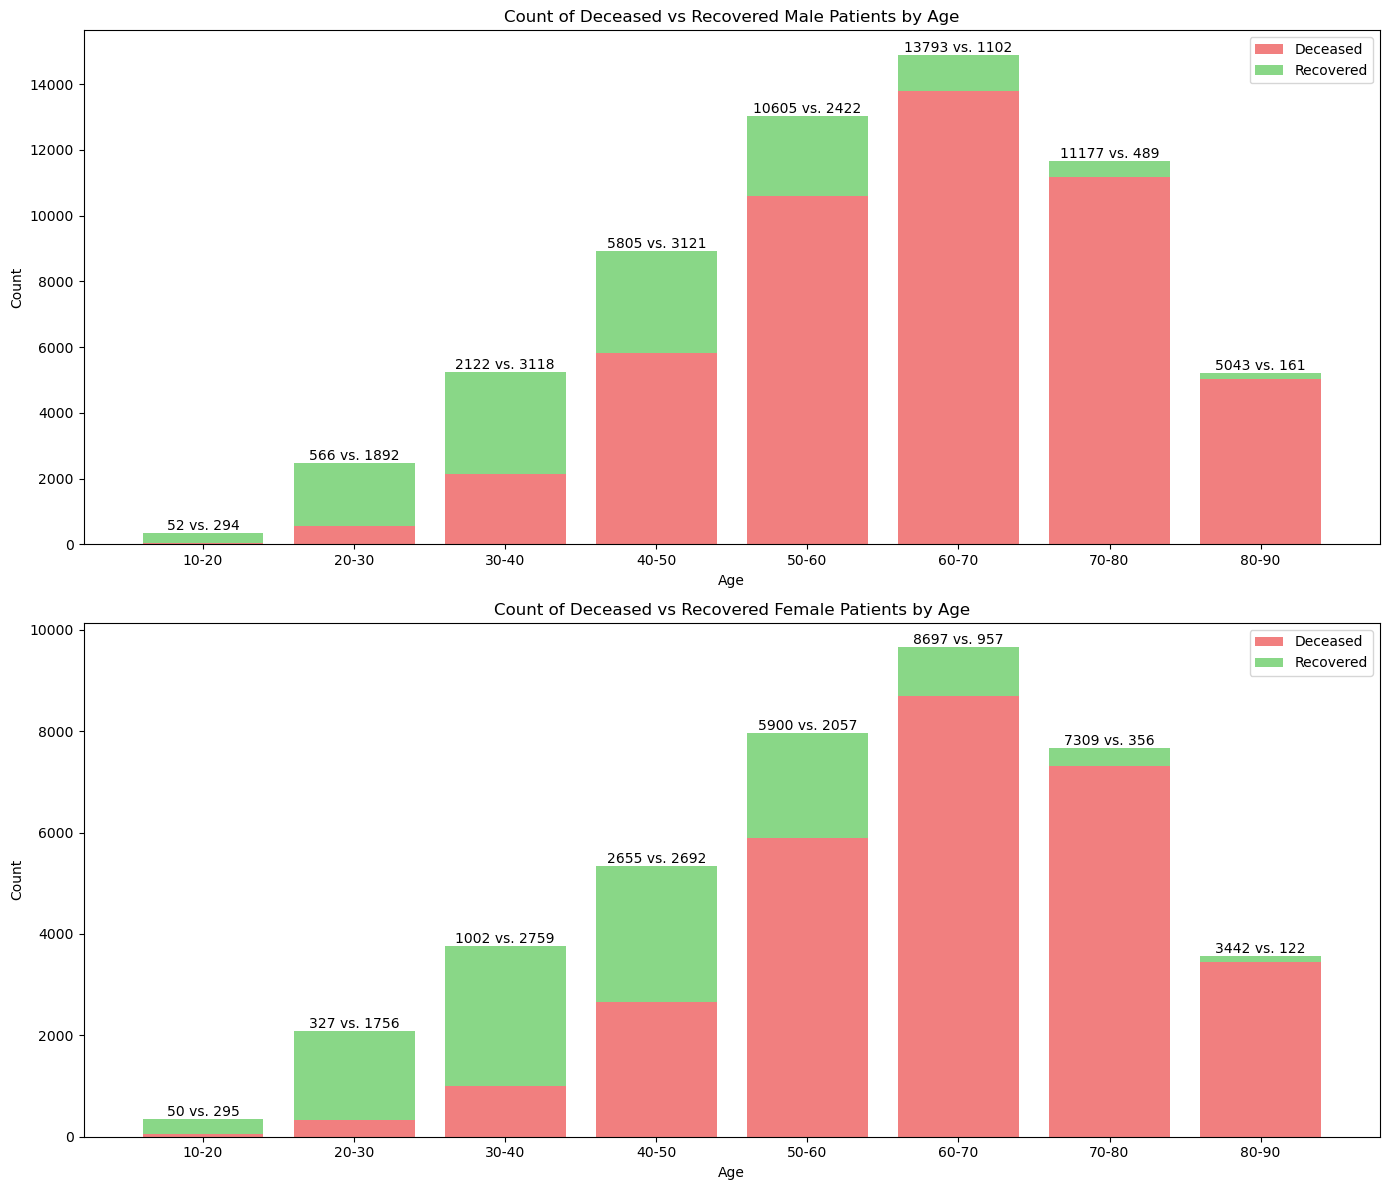

In [22]:
# Group by age group, gender, and deceased status and count occurrences
counts_female = df_anonimity[df_anonimity['sex'] == 1.0].groupby(['age_group', 'deceased_patient']).size().unstack(fill_value=0)
counts_male = df_anonimity[df_anonimity['sex'] == 2.0].groupby(['age_group', 'deceased_patient']).size().unstack(fill_value=0)

# Plotting for male patients
plt.figure(figsize=(14, 12))

# Plot deceased male patients
plt.subplot(2, 1, 1)
plt.bar(counts_male.index, counts_male[1], color='#E50000', label='Deceased', alpha=0.5)
plt.bar(counts_male.index, counts_male[0], bottom=counts_male[1], color='#15B010', label='Recovered', alpha=0.5)
plt.title('Count of Deceased vs Recovered Male Patients by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# Annotating bars with counts for male patients
for age, (recovered, deceased) in zip(counts_male.index, counts_male.values):
    plt.text(age, deceased + recovered, f'{deceased} vs. {recovered}', ha='center', va='bottom')

# Plotting for female patients
plt.subplot(2, 1, 2)

# Plot deceased female patients
plt.bar(counts_female.index, counts_female[1], color='#E50000', label='Deceased', alpha=0.5)
plt.bar(counts_female.index, counts_female[0], bottom=counts_female[1], color='#15B010', label='Recovered', alpha=0.5)
plt.title('Count of Deceased vs Recovered Female Patients by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# Annotating bars with counts for female patients
for age, (recovered, deceased) in zip(counts_female.index, counts_female.values):
    plt.text(age, deceased + recovered, f'{deceased} vs. {recovered}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

These graphs provide valuable insights into the recovery and death rates among different age groups and genders.
- For both males and females, there are more deceased patients than recovered in each age group, except for males aged 10-40 and females aged 10-50 where the number of recovered is higher.
- The gap between the number of recovered and deceased patients seems to narrow as age increases, especially for females.

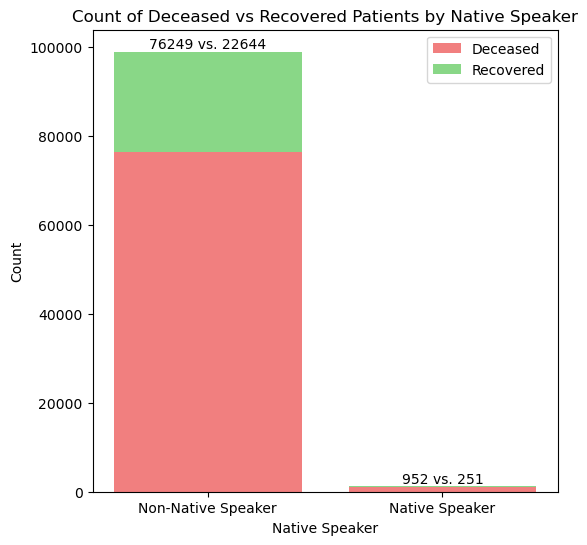

In [23]:
# Group by native speaker and deceased status and count occurrences
counts_native_speaker = df_anonimity.groupby(['native_speaker', 'deceased_patient']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(6, 6))

# Plot deceased patients
plt.bar(counts_native_speaker.index, counts_native_speaker[1], color='#E50000', alpha=0.5, label='Deceased')

# Plot recovered patients
plt.bar(counts_native_speaker.index, counts_native_speaker[0], bottom=counts_native_speaker[1], color='#15B010', alpha=0.5, label='Recovered')

plt.title('Count of Deceased vs Recovered Patients by Native Speaker')
plt.xlabel('Native Speaker')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Native Speaker', 'Native Speaker'])  # Assuming 0=Non-Native Speaker, 1=Native Speaker
plt.legend()

# Annotating bars with counts
for speaker, (recovered, deceased) in zip(counts_native_speaker.index, counts_native_speaker.values):
    plt.text(speaker, deceased + recovered, f'{deceased} vs. {recovered}', ha='center', va='bottom')

plt.show()

As we can observe, the total count for non-native speakers is significantly higher than that for native speakers. Furtheremore, it’s important to note that the count of deceased patients is significantly higher than the count of recovered patients in both groups. However, the difference is much more pronounced for non-native speakers.

In [24]:
df_anonimity[['native_speaker', "deceased_patient"]].groupby('native_speaker', as_index=False).mean().round(4)

,native_speaker,deceased_patient
0,0.0,0.7710
1,1.0,0.7914


This output suggests that the average value of the “deceased_patient” column is slightly higher for the group where “native_speaker” is 1.0 compared to the group where “native_speaker” is 0.0. 

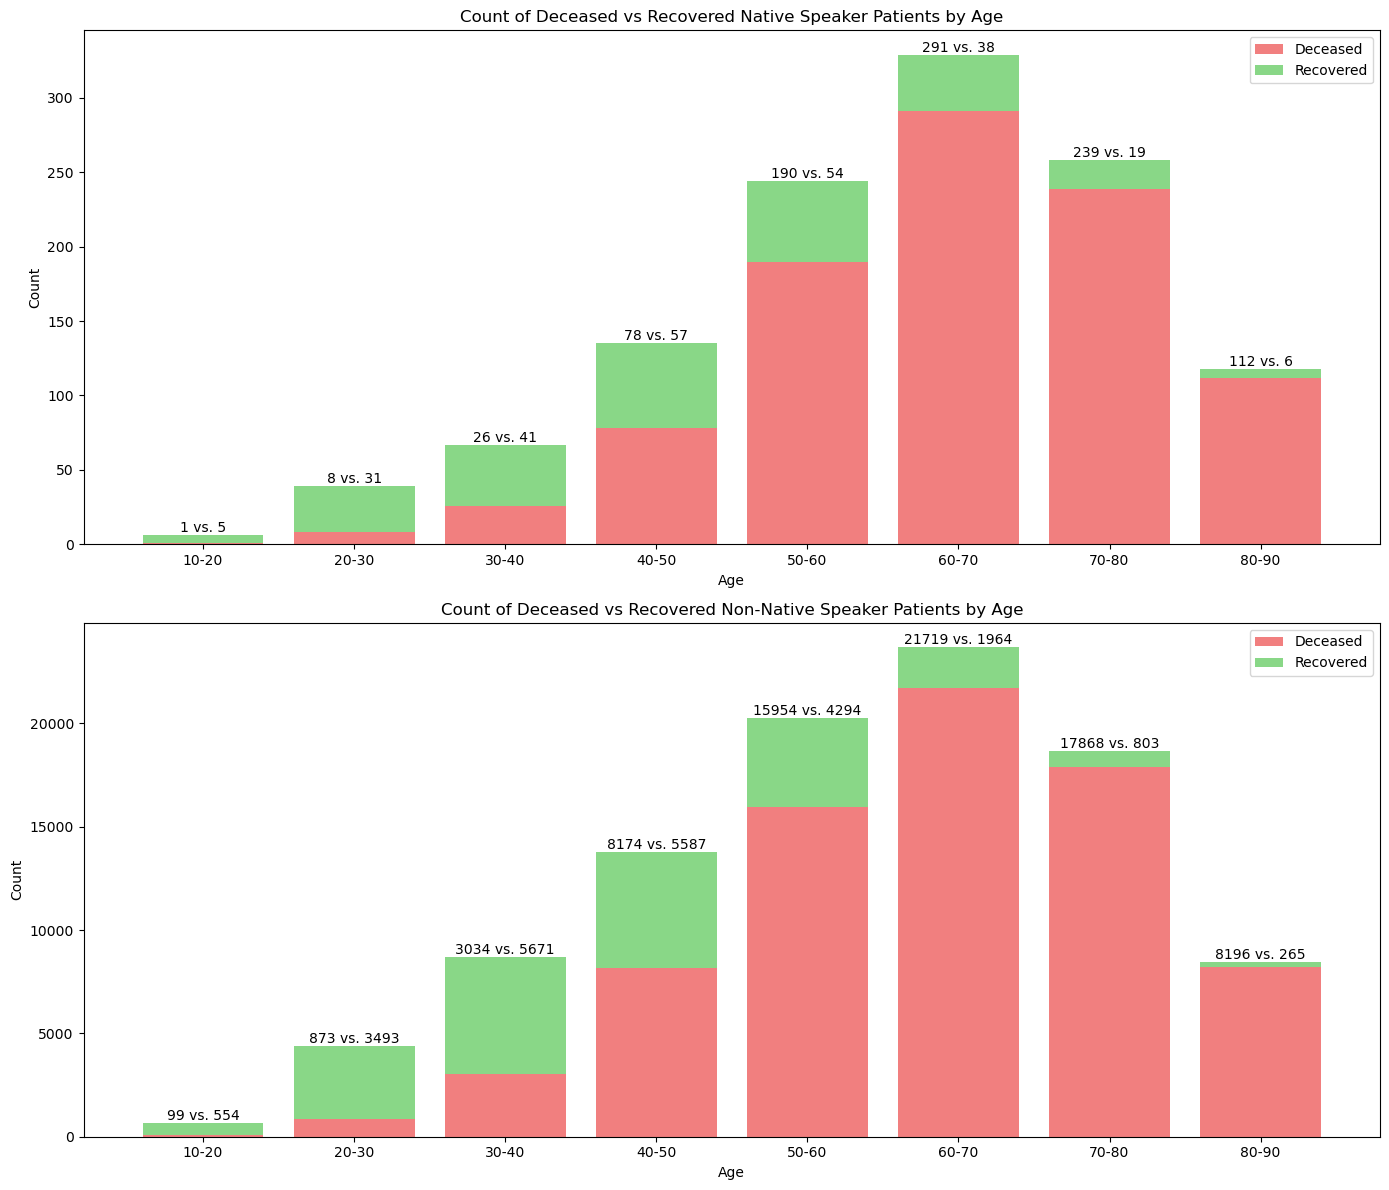

In [25]:
# Group by age group, native speaker, and deceased status and count occurrences
counts_native_speaker = df_anonimity.groupby(['age_group', 'native_speaker', 'deceased_patient']).size().unstack(fill_value=0)

# Separate counts for native speakers and non-native speakers
counts_native = counts_native_speaker.xs(1, level='native_speaker')
counts_non_native = counts_native_speaker.xs(0, level='native_speaker')

# Plotting
plt.figure(figsize=(14, 12))

# Plot deceased patients for native speakers
plt.subplot(2, 1, 1)
plt.bar(counts_native.index, counts_native[1], color='#E50000', alpha=0.5, label='Deceased')
plt.bar(counts_native.index, counts_native[0], bottom=counts_native[1], color='#15B010', alpha=0.5, label='Recovered')
plt.title('Count of Deceased vs Recovered Native Speaker Patients by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# Annotating bars with counts for native speakers
for age, (recovered, deceased) in zip(counts_native.index, counts_native.values):
    plt.text(age, deceased + recovered, f'{deceased} vs. {recovered}', ha='center', va='bottom')

# Plotting for non-native speakers
plt.subplot(2, 1, 2)

# Plot deceased patients for non-native speakers
plt.bar(counts_non_native.index, counts_non_native[1], color='#E50000', alpha=0.5, label='Deceased')
plt.bar(counts_non_native.index, counts_non_native[0], bottom=counts_non_native[1], color='#15B010', alpha=0.5, label='Recovered')
plt.title('Count of Deceased vs Recovered Non-Native Speaker Patients by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# Annotating bars with counts for non-native speakers
for age, (recovered, deceased) in zip(counts_non_native.index, counts_non_native.values):
    plt.text(age, deceased + recovered, f'{deceased} vs. {recovered}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

The data suggests that the impact of the disease varies significantly between native and non-native speakers and across different age groups. 
- Native Speaker Patients: The graph shows that the highest number of deceased patients is in the age group of 80–90. The number of recovered patients is generally lower than the number of deceased patients across all age groups (as exception in the range of 10-40).
- Non-Native Speaker Patients: The counts of both deceased and recovered patients are significantly higher compared to native speakers. The age group of 60–70 has the highest number of deceased patients, while the age group of 30–40 has the highest number of recovered patients.

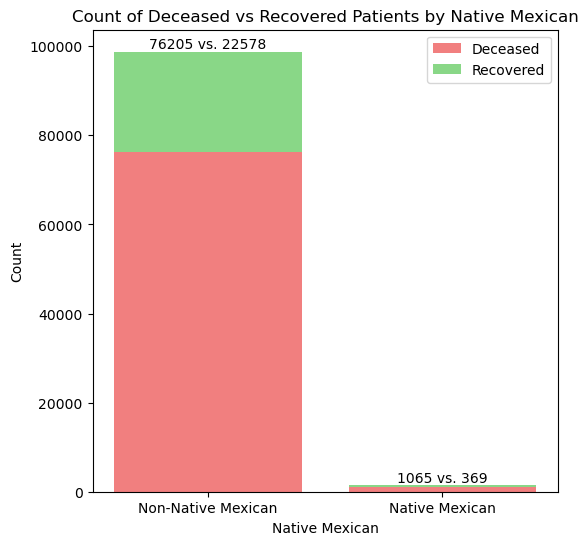

In [26]:
# Group by native Mexican and deceased status and count occurrences
counts_native_mexican = df_anonimity.groupby(['native_mexican', 'deceased_patient']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(6, 6))

# Plot deceased patients
plt.bar(counts_native_mexican.index, counts_native_mexican[1], color='#E50000', alpha=0.5, label='Deceased')

# Plot recovered patients
plt.bar(counts_native_mexican.index, counts_native_mexican[0], bottom=counts_native_mexican[1], color='#15B010', alpha=0.5, label='Recovered')

plt.title('Count of Deceased vs Recovered Patients by Native Mexican')
plt.xlabel('Native Mexican')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Native Mexican', 'Native Mexican'])  # Assuming 0=Non-Native Mexican, 1=Native Mexican
plt.legend()

# Annotating bars with counts
for mexican, (recovered, deceased) in zip(counts_native_mexican.index, counts_native_mexican.values):
    plt.text(mexican, deceased + recovered, f'{deceased} vs. {recovered}', ha='center', va='bottom')

plt.show()

As we can observe, the total count for non-native mexican is significantly higher than that for native mexican.
Additionally, from the numbers, it’s clear that the count of deceased patients is significantly higher than the count of recovered patients in both categories. This could indicate a high mortality rate among the patient population. 

In [27]:
df_anonimity[['native_mexican', "deceased_patient"]].groupby('native_mexican', as_index=False).mean().round(4)

,native_mexican,deceased_patient
0,0.0,0.7714
1,1.0,0.7427


This ouput suggests that the average value of the “deceased_patient” column is slightly higher for the group where “native_mexican” is 0.0 compared to the group where “native_mexican” is 1.0.

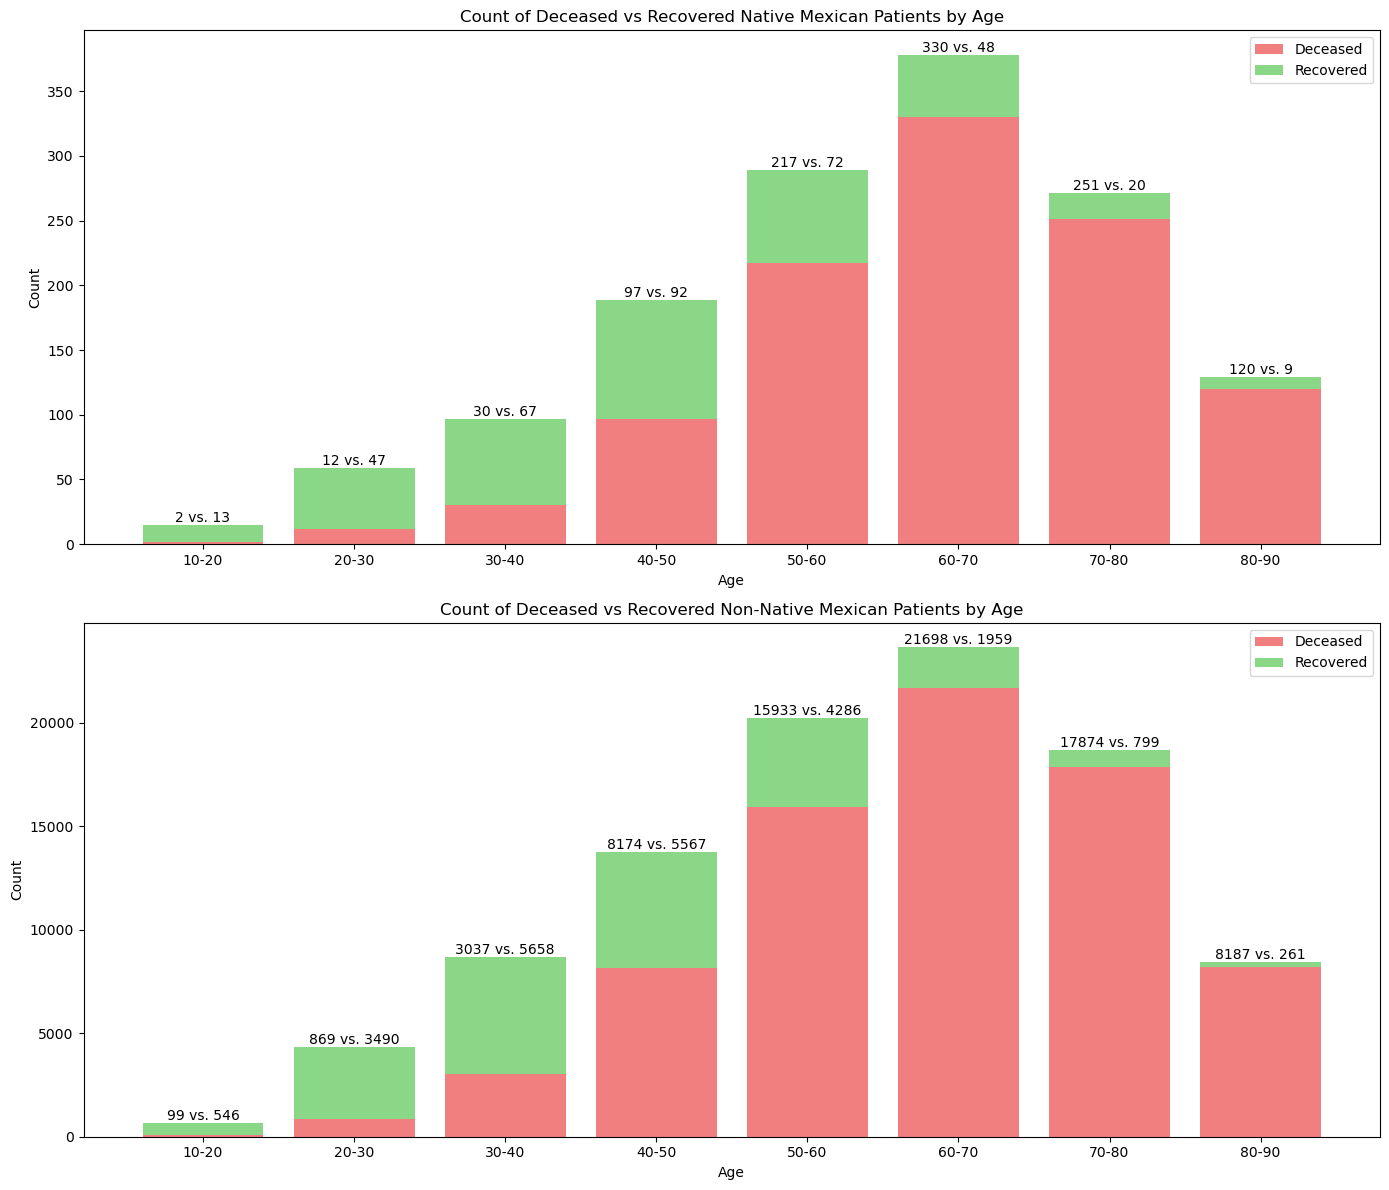

In [28]:
# Group by age group, native Mexican, and deceased status and count occurrences
counts_native_mexican = df_anonimity.groupby(['age_group', 'native_mexican', 'deceased_patient']).size().unstack(fill_value=0)

# Separate counts for native Mexican and non-native Mexican
counts_native = counts_native_mexican.xs(1, level='native_mexican')
counts_non_native = counts_native_mexican.xs(0, level='native_mexican')

# Plotting
plt.figure(figsize=(14, 12))

# Plot deceased patients for native Mexican
plt.subplot(2, 1, 1)
plt.bar(counts_native.index, counts_native[1], color='#E50000', alpha=0.5, label='Deceased')
plt.bar(counts_native.index, counts_native[0], bottom=counts_native[1], color='#15B010', alpha=0.5, label='Recovered')
plt.title('Count of Deceased vs Recovered Native Mexican Patients by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# Annotating bars with counts for native Mexican
for age, (recovered, deceased) in zip(counts_native.index, counts_native.values):
    plt.text(age, deceased + recovered, f'{deceased} vs. {recovered}', ha='center', va='bottom')

# Plotting for non-native Mexican
plt.subplot(2, 1, 2)

# Plot deceased patients for non-native Mexican
plt.bar(counts_non_native.index, counts_non_native[1], color='#E50000', alpha=0.5, label='Deceased')
plt.bar(counts_non_native.index, counts_non_native[0], bottom=counts_non_native[1], color='#15B010', alpha=0.5, label='Recovered')
plt.title('Count of Deceased vs Recovered Non-Native Mexican Patients by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()

# Annotating bars with counts for non-native Mexican
for age, (recovered, deceased) in zip(counts_non_native.index, counts_non_native.values):
    plt.text(age, deceased + recovered, f'{deceased} vs. {recovered}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

These graphs provide a comparative view of the recovery and death rates among different age groups for Native and Non-Native Mexican patients.
- Native Mexican Patients by Age: For ages 10-20, 20-30 and 30-40, there are significantly more recovered patients than deceased. However, for ages 50 and above, the number of deceased patients is higher than those who have recovered.
- Non-Native Mexican Patients by Age: All age groups except for 10-20, 20-30 and 30-40 have more deceased patients than recovered. The highest count of both recovered and deceased patients is in the age group of 50-60 and 60-70 respectively.

These observations could suggest that age is a significant factor in the recovery rate of patients.

## Protected Class

Considering the average mortality rates we’ve calculated:

- For ‘sex’, the mortality rates are 0.728652 for group 1 (female) and 0.796536 for group 2 (male).
- For ‘native_speaker’, the mortality rates are 0.771025 for group 0 (non-native) and 0.791355 for group 1 (native).
- For ‘native_mexican’, the mortality rates are 0.771438 for group 0 (non-native) and 0.742678 for group 1 (native).

So, if we want to protect the group with the highest disparity in mortality rates, ‘sex’ would be the protected class, as it has the largest difference between the two groups. Specifically, we will protect female as is the group with lower rate.

## Sensitive Attributes

As we can observe, the attributes studied above influence the outcome of our analysis in a way that disadvantages one group over another, leading to inequality. For this reason, the sensitive attributes are ‘sex’, ‘native_speaker’, and ‘native_mexican’, as they they relate to personal characteristics of individuals that are protected under anti-discrimination laws.

We cannot forget that medical data, such as illnesses (diabetes, pneumonia, etc.), are also considered sensitive attributes.

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.2] Prepare your dataset and train a model (0.5 point)</h2>
    <hr>
    <p class="mb-0">Split your dataset for train and test [Code]</p>
     <p>Then, train a classifier (scikit-learn model) [Code] considering the question that you should solve [justify]. </p>
</div>



## Preparation

In [29]:
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]
labels = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df.head()

,sex,pneumonia,age,native_speaker,native_mexican,diabetes,epoc,asma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_renal_failure,deceased_patient,age_group
0,1.0,1.0,76.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,70-80
1,2.0,0.0,55.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,50-60
2,1.0,1.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,80-90
3,2.0,1.0,76.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,70-80
10,2.0,1.0,38.0,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,30-40


In [30]:
# Encode the age group column
age_col = df['age_group']
encoder = LabelEncoder()
df['age_group_encoded'] = encoder.fit_transform(age_col)

## Models

### Model 1 (Features: Age)

In [31]:
# Split the data
X1 = df['age_group_encoded']  # Features
y1 = df['deceased_patient']  # Target variable

# Splitting the dataset into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In this case, we have chosed Logistic Regression as the classifier. Logistic Regression is a common choice for binary classification tasks, which seems appropriate for predicting whether a patient is deceased or not based on their age group. 

In [32]:
# Choose a classifier (Logistic Regression, for example)
classifier1 = LogisticRegression()

# Train the classifier on the training data
classifier1.fit(X_train1.values.reshape(-1, 1), y_train1)

# Predict the labels of the test set
y_pred1 = classifier1.predict(X_test1.values.reshape(-1, 1))

# Evaluate the performance of the classifier
accuracy1 = accuracy_score(y_test1, y_pred1)
print("Accuracy:", round(accuracy1, 4))

Accuracy: 0.8214


Although the accuracy is quite high, if we want better accuracy when predicting, we should consider, for example, the top 3 diseases that affect more as you get older.

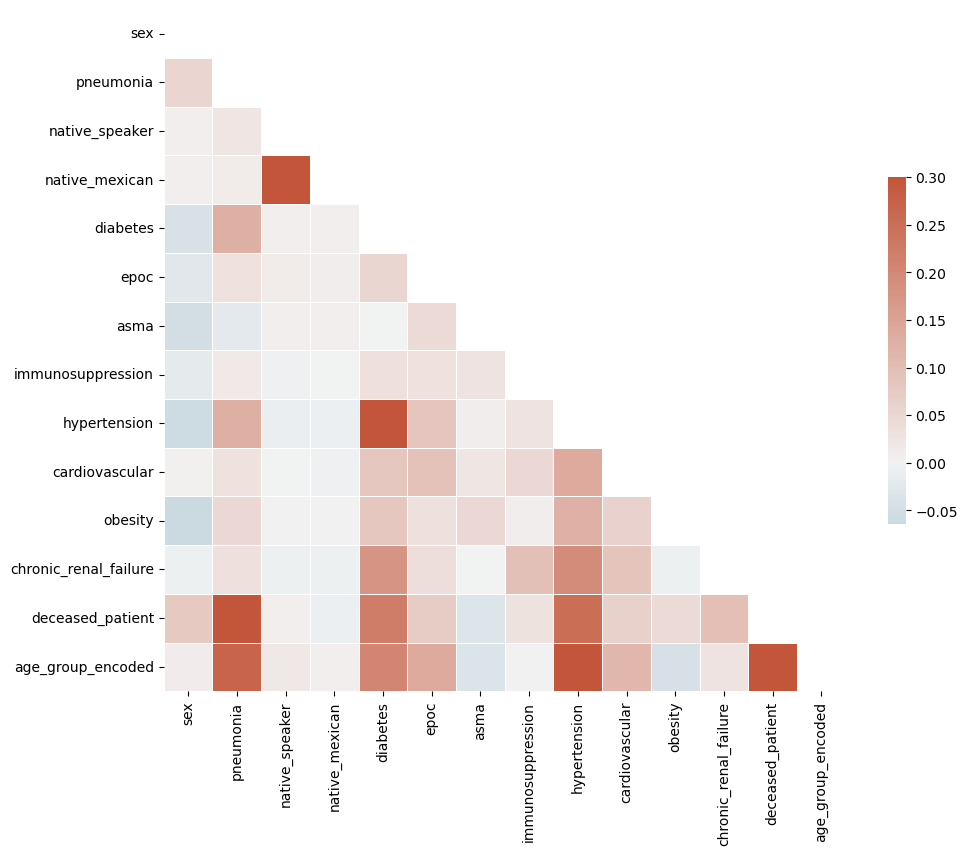

In [33]:
# Compute the correlation matrix
corr = df[['sex', 'pneumonia', 'native_speaker', 'native_mexican', 'diabetes', 'epoc', 'asma', 'immunosuppression', 'hypertension', 'cardiovascular', 'obesity', 'chronic_renal_failure', 'deceased_patient', 'age_group_encoded']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Model 2 (Features: Age, Pneumonia, Hypertension, Diabetes)

As we can observe from the heatmap, the diseases that are more related to age are:

- Pneumonia: Older adults are particularly vulnerable to pneumonia due to age-related declines in immune function and other factors, making it a significant concern for this population in terms of morbidity and mortality.

- Hypertesion: Hypertension, or high blood pressure, becomes more common with age. It increases the risk of heart disease, stroke, and kidney problems.

- Diabetes: Type 2 diabetes is prevalent in older adults due to factors like poor diet and sedentary lifestyle. It causes high blood sugar levels, leading to heart, kidney, and eye issues.

In [34]:
# Drop NaN values from both feature and target datasets
df_aux = df.copy()
df_aux = df_aux.dropna(subset=['age_group_encoded', 'diabetes', 'hypertension', 'pneumonia', 'deceased_patient'])

X2 = df_aux[['age_group_encoded', 'diabetes', 'hypertension', 'pneumonia']] # Features
y2 = df_aux['deceased_patient']  # Target variable

# Splitting the dataset into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Choose a classifier (Logistic Regression, for example)
classifier2 = LogisticRegression()

# Train the classifier on the training data
classifier2.fit(X_train2, y_train2)

# Predict the labels of the test set
y_pred2 = classifier2.predict(X_test2)

# Evaluate the performance of the classifier
accuracy2 = accuracy_score(y_test2, y_pred2)
print("Accuracy:", round(accuracy2, 4))

Accuracy: 0.8697


As initially in our analysis we obtained that the variable "sex" was unbalanced with respect to the dataset, we add it to see if the model learns from it or not.

### Model 3 (Features: Age, Sex, Pneumonia, Hypertension, Diabetes)

In [35]:
# Drop NaN values from both feature and target datasets
df_auxaux = df.copy()
df_auxaux = df_auxaux.dropna(subset=['age_group_encoded', 'sex', 'diabetes', 'hypertension', 'pneumonia', 'deceased_patient'])

X3 = df_auxaux[['age_group_encoded', 'sex', 'diabetes', 'hypertension', 'pneumonia']] # Features
y3 = df_auxaux['deceased_patient']  # Target variable

# Splitting the dataset into training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Choose a classifier (Logistic Regression, for example)
classifier3 = LogisticRegression()

# Train the classifier on the training data
classifier3.fit(X_train3, y_train3)

# Predict the labels of the test set
y_pred3 = classifier3.predict(X_test3)

# Evaluate the performance of the classifier
accuracy3 = accuracy_score(y_test3, y_pred3)
print("Accuracy:", round(accuracy3, 4))

Accuracy: 0.8737


As we can finally see, our last model has greater accuracy. So, maybe for people it may seem not relevant, but sometimes illnesses affect different to men and women.

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.3] Assess your model performance (1 point)</h2>
    <hr>
    <p class="mb-0">You should analyse the following analysis:</p>
    <ol>
        <li>Performance metrics [interpret]</li>
        <li>Use Specificity to understand how well it classifies TRUE NEGATIVES (important for COVID) [Interpret</li>
        <li>Training a XGB regressor analyse the risk factors used in this dataset and how they impact on your protected class.  [Code and Interpret]</li>
    </ol>
     
</div>

<div class="alert alert-block alert-info col-md-12">
    <p><b>Specificity metric:</b> (true negative rate) is the probability of a negative test result, conditioned on the individual truly being negative. This is important on COVID-19 detection because we know that is hard to detect the infection, therefore there has been many false negatives, resulting in underidentification.</p>
    <p><b>Analysing factors:</b> When using multiple attributes for a classifier, each attribute can have a different impact in the precision of the algorithm, which also varies regarding the dataset. Understanding the weights of each factor can help to understand what are the effects on the protected class.</p>
</div>

## Performance metrics

Model Performance Analysis - LogisticRegression()_v3
Accuracy: 0.8737
ROC AUC: 0.7845
Precision: 0.8933
Recall: 0.9495

Classification report - summary:
              precision    recall  f1-score   support

           0       0.79      0.62      0.69      4685
           1       0.89      0.95      0.92     15717

    accuracy                           0.87     20402
   macro avg       0.84      0.78      0.81     20402
weighted avg       0.87      0.87      0.87     20402



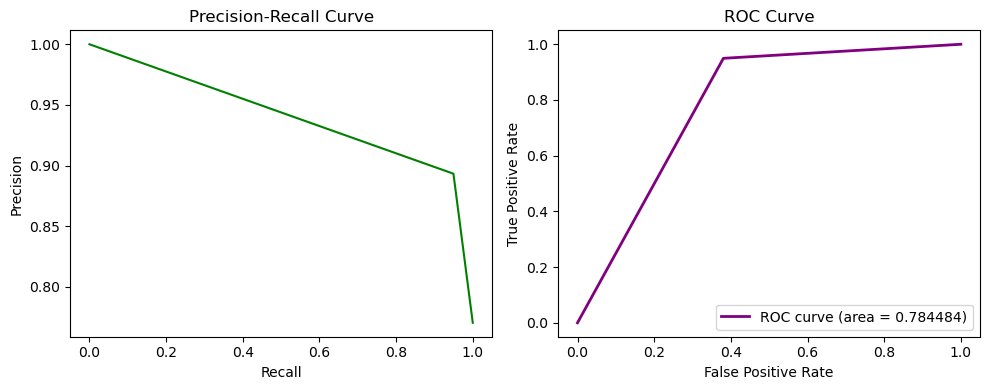

In [36]:
model_name = classifier3

# Compute performance metrics
accuracy = accuracy_score(y_test3, y_pred3)
roc_auc = roc_auc_score(y_test3, y_pred3)
precision = precision_score(y_test3, y_pred3)
recall = recall_score(y_test3, y_pred3)

 # Display results
print(f'Model Performance Analysis - {model_name}_v3')
print('Accuracy:', round(accuracy, 4))
print('ROC AUC:', round(roc_auc, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))

# Classification report
print('\nClassification report - summary:')
print(classification_report(y_test3, y_pred3, zero_division='warn'))

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test3, y_pred3)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test3, y_pred3)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot Precision-Recall curve
ax1.plot(recall, precision, color='green')
ax1.set_xlabel('Recall', size=10)
ax1.set_ylabel('Precision', size=10)
ax1.set_title('Precision-Recall Curve', size=12)


# Plot ROC curve
ax2.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %f)' % roc_auc)
ax2.set_title('ROC Curve', size=12)
ax2.set_xlabel('False Positive Rate', size=10)
ax2.set_ylabel('True Positive Rate', size=10)
ax2.legend(loc="lower right")

# Show plots
plt.tight_layout()
plt.show()

In summary, the model seems to perform well in predicting whether a patient is deceased for covid based on the  features related to the age, with high accuracy, precision, and recall, and a fairly good ROC AUC score. (See the report for more detail)

## Specificity (with FP & FN)

Model Error Analysis - LogisticRegression()
False Positive Rate: 0.3806
False Negative Rate: 0.0505


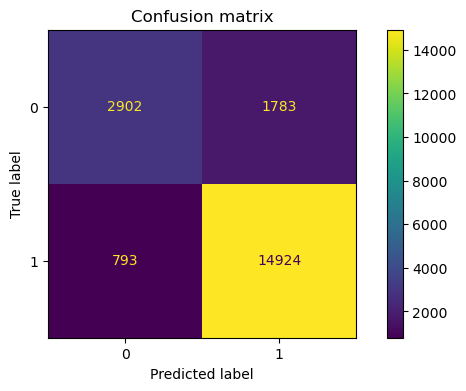

In [37]:
# Confusion matrix 
conf_matrix = confusion_matrix(y_test3, y_pred3)

# Compute FPR and FNP - errors
fpr = conf_matrix[0][1]/conf_matrix[0].sum()
fnp = conf_matrix[1][0]/conf_matrix[1].sum()

print(f"Model Error Analysis - {model_name}")
print('False Positive Rate:', round(fpr, 4))
print('False Negative Rate:', round(fnp, 4))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix)
fig, ax = plt.subplots(figsize=(8, 4))
disp.plot(ax=ax)

plt.title('Confusion matrix')
plt.show()

In summary, the model seems to have a relatively high false positive rate, which could be problematic if the cost of false positives is high (not in our case, it might be useful for prevention). On the other hand, the false negative rate is quite low, which is good if the cost of false negatives is high (that is, almost all deaths can be detected).

In [38]:
# Compute specificity
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("Specificity:", round(specificity, 4))

Specificity: 0.6194


The specificity indicates that the model is fairly good at predicting negative instances correctly, but there is still room for improvement.

## Using XGB regressor + Feature's importance

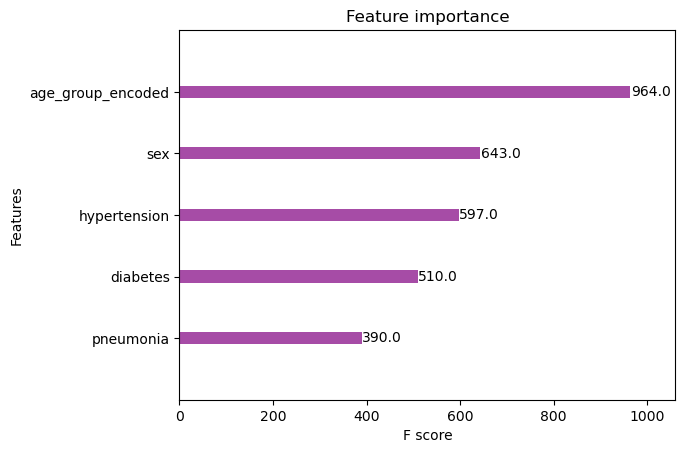

In [39]:
# Preparing the data by changing the dtype of columns
s = X_train3.select_dtypes(include='object').columns
X_train3[s] = X_train3[s].astype("float")

# Training an XGBoost classifier
barWidth = 0.9
model = XGBClassifier(objective="binary:logistic")
model.fit(X_train3, y_train3)

# Plot feature importance
plot_importance(model, grid=False, color='purple', alpha=0.7)
plt.show()

From documentation: The plot_importance function is used to visualize the importance of each feature used in the model. The importance of a feature is calculated based on the number of times a feature appears in the trees of the model. The more an attribute is used to make key decisions in the trees, the higher its relative importance.

From the plot, we can observe that the feature ‘age_group_encoded’ has the highest importance, followed by ‘pneumonia’, ‘hypertension’, ‘diabetes’, and ‘sex’. This means that ‘age_group_encoded’ was the most useful feature for making predictions in this model, while ‘sex’ was the least useful.

In summary, the model finds ‘age_group_encoded’ to be the most important feature in predicting whether a patient is deceased for covid, which could suggest that age plays a significant role in the outcome. (See the report for more detail)

## Using SHAP (knowledge from Visual Analytics)

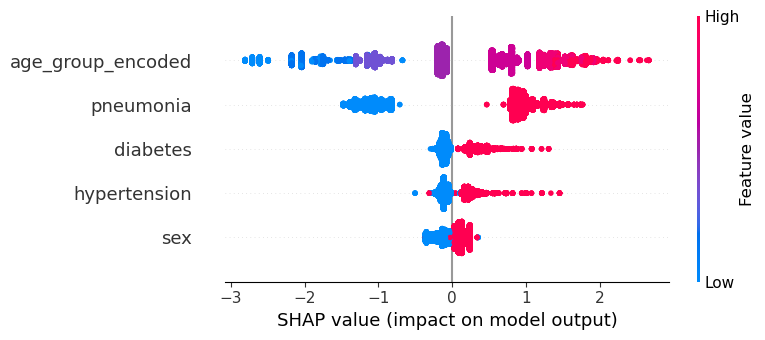

In [40]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test3)


shap.summary_plot(shap_values, X_test3)

As we know from the subject of visual analytics, the SHAP summary plot provides a detailed view of the feature importance and their impacts on the model’s output. In this case, it shows that pneumonia and age group are the most influential features in predicting whether a patient is deceased for covid. (See the report for more detail)

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.4] Assess the fairness metrics (1 point)</h2>
    <hr>
    <p class="mb-0">Assess the performance from the fairness point of view of the created model.</p>
    <p>For that, you should plot the result of some fairness metric for classification.</p>
    <p> You can just use the same metrics we used in Part 1, but remember to add other metrics if you need them to detect changes of performance in the following exercises.</p>
</div>

In [41]:
# convert into df to be able to apply the binary label
y_test3 = y_test3.to_frame()
y_pred3 = pd.Series(y_pred3, index=X_test3.index).to_frame().rename(columns={0: 'deceased_patient'})

In [42]:
# needed to perform the classification metric
# Convert true labels (y_test3) into a BinaryLabelDataset
dataset_true = BinaryLabelDataset(df=y_test3, label_names=['deceased_patient'], 
                                  protected_attribute_names=[], favorable_label=1, unfavorable_label=0)

# Convert predicted labels (y_pred3) into a BinaryLabelDataset
dataset_pred = BinaryLabelDataset(df=y_pred3, label_names=['deceased_patient'], 
                                  protected_attribute_names=[], favorable_label=1, unfavorable_label=0)


In [43]:
# Create a ClassificationMetric object
metric = ClassificationMetric(dataset_true, dataset_pred)

### Unfairness mitigation algorithms  in AIF360
The library contains a set of algorithms to mitigate potential unfairness in machine-learning pipelines.

The provided algorithms correspond implementation of to state of the art techniques (most of them contain a link to a scientific paper that introduced them).

The existing algorithms can be found [here](https://aif360.readthedocs.io/en/latest/modules/algorithms.html).

They are divided between:
- **Preprocessing.** Algorithms that are applied before starting the learning process (modification of the input data before feeding it to the model).

- **Inprocessing.** Algorithms that are applied during the learning process (e.g.: modification of the loss function to account for fairness).

- **Postprocessing.** Algorithms that are applied after the predictions of the models, substituting them for more fair solutions.

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.5] Apply mitigation algorithms to your model (0.5 points)</h2>
    <hr>
     <p class="mb-0">Apply an unfairness mitigation algorithm of your election, train a new classifier of the same family used above and assess the new performance from the fairness point of view.</p>
    <p>Provide a textial description of the results (max 3 lines).</p>
</div>



<div class="alert alert-block alert-info col-md-12">

<p>Although you can try other algorihtms if you want, the suggested algorithms to mitigate unfairness are the following:</p>

    
<ul>
<li><b><a href="https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.DisparateImpactRemover.html" >Preprocessing</a></b>
<ul>
<li>Disparate Impact Remover</li>
<li>Rewighing (you need a classifier that allows you to parametrize sample weights for this)</li>
</ul>

</li>
<li><b><a href="https://aif360.readthedocs.io/en/latest/modules/algorithms.html#aif360-algorithms-inprocessing">Inprocessing</a></b>
<ul>
<li>MetaFairClassifier</li>
</ul>
</li>
<li><b><a href="https://aif360.readthedocs.io/en/latest/modules/algorithms.html#module-aif360.algorithms.postprocessing">Postprocessing</a></b>
<ul>
<li>Disparate Impact Remover</li>
<li>EqOddsPostprocessing (You need to use the equalized odds ratio to measure performance of this classifier and the classifier trained above)</li>
</ul>
</li>
</ul>

<p>You can add necessary imports for using the algorithm</p>

</div>


<div class="alert alert-block alert-warning col-md-12">
    <p>Sometimes, certain algorithms do not work well with certain classifiers / output distributions</p>
    <p>This can happen for several reasons, one of them being the changes done for subsequent versions of the tool</p>
    <br>
    <p><b>If you see that your unfairness mitigation algorithm does not work as expected, do not invest too much time trying to solve it, use another algorithm.</b></p>
</div>   

In [44]:
## Your code here

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.6] Assess the effects of the mitigation technique (1 point)</h2>
    <hr>
     <p class="mb-0">Analyse the performance of the effects of the mitigation algorithm in the performance of your model. You can iterate over your training to get the best result (in relation to you goal). Explain how do arrive to the best choice and why it is the best one.</p>
</div>


In [45]:
## Your code here

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.7] Executive report (5 points)</h2>
    <hr>
     <p class="mb-0">After analysing your dataset and training your models, please create a 1-3 page report containing the following items (on your consideration): </p>
    <ul>
        <li>Anonymization of the dataset</li>
        <li>Fairness in original dataset</li>
        <li>Factors that impact on discrimination</li>
        <li>Fairness metrics</li>
        <li>Algorithms used for training the model</li>
        <li>Algorithmic performance expected and obtained</li>
        <li>Algorithmic metrics applied</li>
        <li>Algorithmic performance after the metrics</li>
        <li>Conclusions regarding the goal of your model and the expected utility in a real-case scenario</li>
    </ul>
</div>

<div class="alert alert-block alert-warning">
<p>You can include figure if you consider necessary, and you can reuse observations from the notebook, please avoid placing code in the report.</p>
<p>Please, include the contribution of each of the team mates to this project. </p>
</div> 
